In [1]:
bb_box_list = glob.glob("/ssd_scratch/cvit/ashishmenon/visualization_output_4/bb_box/BRCA/*/*")
bb_box_list.sort()
bb_box_list

NameError: name 'glob' is not defined

In [1]:
from PIL import Image, ImageDraw
import cv2
import glob
import os
import json 
import cv2
import glob
import numpy as np
import shutil
import os
import itertools
from matplotlib import pyplot as plt
from PIL import Image
import json 
from sklearn.metrics import jaccard_score
import multiprocessing
from multiprocessing import Pool
import pandas as pd
import argparse
import cv2
from matplotlib import pyplot as plt


def bb_intersection_over_union(truth_coords_og, pred_coords_og):
    truth_coords = list(truth_coords_og).copy()
    pred_coords = list(pred_coords_og).copy()
    pred_area = pred_coords[2]*pred_coords[3]
    truth_area = truth_coords[2]*truth_coords[3]
    
    truth_coords[2]+=truth_coords[0]
    truth_coords[3]+=truth_coords[1]
    
    pred_coords[2]+=pred_coords[0]
    pred_coords[3]+=pred_coords[1]
    
    # coords of intersection rectangle
    x1 = max(truth_coords[0], pred_coords[0])
    y1 = max(truth_coords[1], pred_coords[1])
    x2 = min(truth_coords[2], pred_coords[2])
    y2 = min(truth_coords[3], pred_coords[3])
    # area of intersection rectangle
    interArea = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    # area of prediction and truth rectangles
    boxTruthArea = (truth_coords[2] - truth_coords[0] + 1) * (truth_coords[3] - truth_coords[1] + 1)
    boxPredArea = (pred_coords[2] - pred_coords[0] + 1) * (pred_coords[3] - pred_coords[1] + 1)
    # intersection over union 
    dr  = boxTruthArea+boxPredArea-interArea
    if dr==0:
        iou=1
    else:
        iou = interArea / float(boxTruthArea + boxPredArea - interArea)
    return iou



def check_list_of_lists(list_gt):
    if type(list_gt[0]) != type(list_gt):
        list_gt_up = []
        list_gt_up.append(list_gt)
    else:
        list_gt_up = list_gt
    return list_gt_up

def get_iou_from_lists(list_gt,list_pr):
    iou_list = []
    list_gt_up = check_list_of_lists(list_gt)
    list_pr_up = check_list_of_lists(list_pr)
    for i,j in itertools.product(list_pr_up,list_gt_up):
        iou_list.append(bb_intersection_over_union(i,j))
    return np.max(iou_list)
    
def get_unique_items(x):
    list_x = x.values()
    list_x_u = list(list_x for list_x,_ in itertools.groupby(list_x))
    return list_x_u

def get_area(x):
    return abs(x[2])*abs(x[3])

def remove_redundant_bb(bb_list):
    to_remove_coord = []
    for k in itertools.combinations(bb_list,2):
        iou_req = get_iou_from_lists(k[0],k[1])
        if iou_req>0:
            area1=get_area(k[0])
            area2=get_area(k[1])
            to_remove_coord.append(k[np.argmin([area1,area2])])
    for i in to_remove_coord:
        try:
            bb_list.pop(bb_list.index(i))
        except:
            continue
    return bb_list


def get_iou_from_fp(gt_fp,pr_fp):
    with open(gt_fp,'r') as f:
        s1 = json.load(f)
    gt_list = get_unique_items(s1)
    gt_list = remove_redundant_bb(gt_list)
    with open(pr_fp,'r') as f:
        s2 = json.load(f)
    pr_list = get_unique_items(s2)
    pr_list = remove_redundant_bb(pr_list)
    iou = get_iou_from_lists(gt_list,pr_list)
    return iou,gt_fp   


def get_jaccard(fp_gt,fp_pr):
    overall_jcard = []
    orig_img1 = cv2.imread(fp_gt)
    orig_img1 = cv2.resize(orig_img1, (224,224))
    orig_img2 = cv2.imread(fp_pr)
    orig_img2 = cv2.resize(orig_img2, (224,224))
    x1 = np.uint8(orig_img1/255)
    x2 = np.uint8(orig_img2/255)
    overall_jcard = jaccard_score(x2.reshape(-1), x1.reshape(-1))
    return overall_jcard,fp_gt


def get_threshold_from_hm(heatmap_addr):
    heatmap = Image.open(heatmap_addr)
    heatmap = heatmap.convert('RGB')
    heatmap = np.array(heatmap)
    heatmap = heatmap[:, :, ::-1].copy()
    hsv = cv2.cvtColor(heatmap, cv2.COLOR_BGR2HSV)

    ## mask of green (36,25,25) ~ (86, 255,255)
    # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    mask = cv2.inRange(hsv, (20, 25, 25), (70, 255,255))

    ## slice the green
    imask = mask>0
    green = np.zeros_like(heatmap, np.uint8)
    green[imask] = heatmap[imask]
    grey_img = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(grey_img,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return thresh

def get_bb(orig_img,thresh):    
    threshold = 150
    canny_output = cv2.Canny(thresh, threshold, threshold * 2)

    try:
        _, contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    except:
        contours,_ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)   
    

    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])

    boundRect = [tuple(x) for x in set(tuple(x) for x in boundRect)]
    boundRect = remove_redundant_bb(boundRect)
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    boxes = {}
    for i in range(len(boundRect)):
        color = (0, 255, 0)
        x = int(boundRect[i][0])
        y = int(boundRect[i][1])
        w = int(boundRect[i][2])
        h = int(boundRect[i][3])
        boxes['box{}'.format(i)] = [x,y,w,h]
        cv2.rectangle(orig_img, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
    
    return orig_img,boxes



In [2]:
import itertools
def remove_redundant_bb(bb_list):
    to_remove_coord = []
    for k in itertools.combinations(bb_list,2):
        iou_req = get_iou_from_lists(k[0],k[1])
        if iou_req>0:
            area1=get_area(k[0])
            area2=get_area(k[1])
            to_remove_coord.append(k[np.argmin([area1,area2])])
    for i in to_remove_coord:
        try:
            bb_list.pop(bb_list.index(i))
        except:
            continue
    return bb_list

def crop_based_on_coo(orig_img_addr,shapes):
    a = []
    for shape in shapes:
        x = Image.open(orig_img_addr)
        x = x.crop([shape[0],shape[1],shape[0]+shape[2],shape[1]+shape[3]])
        a.append(x)
    return a

In [3]:
original_image_paths = glob.glob('/ssd_scratch/cvit/ashishmenon/COAD_cancer_patches_expt_data/*/*.png')
visualization_heatmap_pths = glob.glob('/ssd_scratch/cvit/ashishmenon/visualization_output_4_train/COAD_COAD/gc_th/*/*.png')
cam_on_img_pth = glob.glob('/ssd_scratch/cvit/ashishmenon/visualization_output_4_train/COAD_COAD/gc_simp/*/*.png')
visualized_patches = [i.split('/')[-2] for i in glob.glob('/ssd_scratch/cvit/ashishmenon/visualization_output_4_train/COAD_COAD/gc_th/*/*.png')]
required_original_paths = [i for i in original_image_paths if i.split('/')[-1].split('.png')[0] in visualized_patches]
required_original_paths.sort()
visualized_patches.sort()
visualization_heatmap_pths.sort()
cam_on_img_pth.sort()
print(len(required_original_paths),len(visualization_heatmap_pths),len(cam_on_img_pth))

12672 12672 12672


In [4]:
def get_connected_components(img_pil):
    img = np.array(img_pil)
    img = cv2.cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
    num_labels, labels_im = cv2.connectedComponents(img)
    return num_labels,labels_im

In [5]:
for N,i in enumerate(visualization_heatmap_pths):
    orig_img_address = required_original_paths[N]
    patch_name = orig_img_address.split('/')[-1]
#     print(i.split('/')[-1],patch_name)
    model_used = 'BRCA'
    inferred_on = 'COAD'
#     print(model_used,inferred_on)
    cross_organ_address = i.replace('COAD_COAD','BRCA_COAD')
    
    
#     img1 = get_threshold_from_hm(i)
#     img2 = get_threshold_from_hm(cross_organ_address)        
    
    img1 = cv2.imread(i)
    img2 = cv2.imread(cross_organ_address)
    
    img2_original = cv2.imread(orig_img_address)
    # img1 = img1/255
    # img2 = img2/255
    img_ov = cv2.bitwise_and(img1,img2)
    img_organ_specific = img1-img_ov
    img_cross_organ_specific = img2-img_ov
    
    
    resized_bwa = cv2.resize(img1, (512, 512),interpolation = cv2.INTER_NEAREST) #since overlap of heatmaps is on 224X224 but we want the crop of the original image
    boxed_image, boxes = get_bb(img2_original,resized_bwa)
    cropped_img_list = crop_based_on_coo(orig_img_address,[boxes[i] for i in boxes.keys()])
       
    for n,pils in enumerate(cropped_img_list):
        num_labels,_ = get_connected_components(pils)
        if num_labels>15:
            print("saving total")
            save_folder = '/ssd_scratch/cvit/ashishmenon/{}_{}_{}_total/'.format(model_used,inferred_on,inferred_on)
            save_path = save_folder+i.split('/')[-2][0:12]+'/'+ patch_name.split('.')[0]
            os.makedirs(save_path,exist_ok=True)
            pils.save(save_path+'/{}.png'.format(n))
            
    
    resized_bwa = cv2.resize(img2, (512, 512),interpolation = cv2.INTER_NEAREST) #since overlap of heatmaps is on 224X224 but we want the crop of the original image
    boxed_image, boxes = get_bb(img2_original,resized_bwa)
    cropped_img_list = crop_based_on_coo(orig_img_address,[boxes[i] for i in boxes.keys()])
       
    for n,pils in enumerate(cropped_img_list):
        num_labels,_ = get_connected_components(pils)
        if num_labels>15:
            print("saving total")
            save_folder = '/ssd_scratch/cvit/ashishmenon/{}_{}_{}_total/'.format(model_used,inferred_on,model_used)
            save_path = save_folder+i.split('/')[-2][0:12]+'/'+ patch_name.split('.')[0]
            os.makedirs(save_path,exist_ok=True)
            pils.save(save_path+'/{}.png'.format(n))
    
    
    resized_bwa = cv2.resize(img_ov, (512, 512),interpolation = cv2.INTER_NEAREST) #since overlap of heatmaps is on 224X224 but we want the crop of the original image
    boxed_image, boxes = get_bb(img2_original,resized_bwa)
    cropped_img_list = crop_based_on_coo(orig_img_address,[boxes[i] for i in boxes.keys()])
       
    for n,pils in enumerate(cropped_img_list):
        num_labels,_ = get_connected_components(pils)
        if num_labels>15:
            print("saving overlapped")
            save_folder = '/ssd_scratch/cvit/ashishmenon/{}_{}_overlapped/'.format(model_used,inferred_on)
            save_path = save_folder+i.split('/')[-2][0:12]+'/'+ patch_name.split('.')[0]
            os.makedirs(save_path,exist_ok=True)
            pils.save(save_path+'/{}.png'.format(n))
    
    
    resized_bwa = cv2.resize(img_cross_organ_specific, (512, 512),interpolation = cv2.INTER_NEAREST) #since overlap of heatmaps is on 224X224 but we want the crop of the original image
    boxed_image, boxes = get_bb(img2_original,resized_bwa)
    cropped_img_list = crop_based_on_coo(orig_img_address,[boxes[i] for i in boxes.keys()])
    for n,pils in enumerate(cropped_img_list):
        num_labels,_ = get_connected_components(pils)
        if num_labels>15:
            print("saving {}_specific".format(model_used))
            save_folder = '/ssd_scratch/cvit/ashishmenon/{}_{}_{}_specific/'.format(model_used,inferred_on,model_used)
            save_path = save_folder+i.split('/')[-2][0:12]+'/'+ patch_name.split('.')[0]
            os.makedirs(save_path,exist_ok=True)
            pils.save(save_path+'/{}.png'.format(n))
        
    
    resized_bwa = cv2.resize(img_organ_specific, (512, 512),interpolation = cv2.INTER_NEAREST) #since overlap of heatmaps is on 224X224 but we want the crop of the original image
    boxed_image, boxes = get_bb(img2_original,resized_bwa)
    cropped_img_list = crop_based_on_coo(orig_img_address,[boxes[i] for i in boxes.keys()])
    for n,pils in enumerate(cropped_img_list):
        num_labels,_ = get_connected_components(pils)
        if num_labels>15:
            print("saving {}_specific".format(inferred_on))
            save_folder = '/ssd_scratch/cvit/ashishmenon/{}_{}_{}_specific/'.format(model_used,inferred_on,inferred_on)
            save_path = save_folder+i.split('/')[-2][0:12]+'/'+ patch_name.split('.')[0]
            os.makedirs(save_path,exist_ok=True)
            pils.save(save_path+'/{}.png'.format(n))

saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
s

saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_

saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
s

saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specifi

saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving

saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_spec

saving COAD_specific
saving total
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_

saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving

saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
s

saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving

saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
savi

saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving ov

saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving tot

saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
savi

saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total

saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving total
saving total
saving

saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
savi

saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specifi

saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BR

saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
savi

saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving to

saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_spe

saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_

saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
sa

saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving total
saving total
sav

saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving

saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped

saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_speci

saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving C

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRC

saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
savi

saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
savi

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
s

saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_speci

saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving ov

saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
s

saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving 

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving to

saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_s

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
sav

saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
savin

saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
sav

saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_sp

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving

saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving to

saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
s

saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
sav

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BR

saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving tota

saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_

saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving 

saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
sa

saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving 

saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total

saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
s

saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving CO

saving overlapped
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
savi

saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_sp

saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving

saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving tota

saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
sav

saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
sav

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving

saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
sav

saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving t

saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overl

saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving 

saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving 

saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving

saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
sav

saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving t

saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_

saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_sp

saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overl

saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving tot

saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specifi

saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_sp

saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
savi

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific

saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specifi

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving tot

saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving overlapped
s

saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving 

saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specifi

saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving ov

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving o

saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_spe

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_sp

saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving ov

saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
sav

saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving t

saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
s

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total

saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving B

saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_speci

saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving to

saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total

saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving CO

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving CO

saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
sav

saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
sa

saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving 

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving tota

saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
s

saving COAD_specific
saving total
saving COAD_specific
saving total
saving BRCA_specific
saving BRCA_specific
saving total
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
s

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving COAD_specific
saving total
saving total
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped

saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving total
saving overlap

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
savi

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving BRCA_specific
saving total
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving BRCA_specific
saving total
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving COAD_specific
saving total
s

saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving total
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving COAD_specific
saving total
saving total
saving total
saving 

saving BRCA_specific
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving total
saving overlapped
saving total
saving total
saving total
saving overlapped
saving COAD_specific
saving COAD_specific
saving total
saving

saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
s

saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific

saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA

saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving tota

saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving

saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving to

saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_sp

saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving B

saving total
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving to

saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BR

saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
sav

saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
sa

saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specifi

saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
savi

saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped

saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving

saving overlapped
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overl

saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving

saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
savin

saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
s

saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving total
saving BRCA_specific
saving total
saving BRCA_specific
saving total
saving total
saving total
saving

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving COAD_specific
saving COAD_specific
saving total
saving total

saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_speci

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_

saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving ove

saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
s

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_sp

saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_

saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving COAD_speci

saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_speci

saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
sav

saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving COAD_specific
saving COAD_specific
saving COAD_specific
saving total
s

saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
savi

saving total
saving BRCA_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BR

saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD

saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_sp

saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_speci

saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving 

saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
s

saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving BRCA_specific
saving BRCA

saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlappe

saving COAD_specific
saving total
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving BRCA_specific
saving COAD_specific
saving COAD_specific
saving total
saving BRCA_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving COAD_specific
saving total
saving total
saving total
saving overlapped
saving BRCA_specific
saving

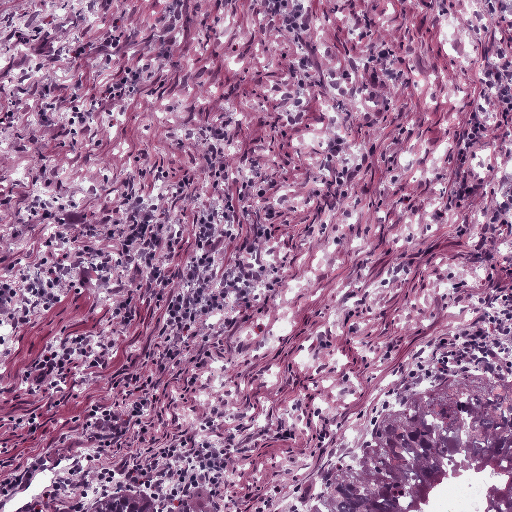

In [58]:
Image.open(orig_img_address)

In [7]:
import glob
import cv2
for i in glob.glob("/ssd_scratch/cvit/ashishmenon/nuclei_segmented_outputs_BRCA_COAD_2/*/*.png"):
    img = cv2.imread(i,0)
    if(len(np.unique(img,return_counts=True)[0]))==1:
        os.remove(i)

In [62]:
gt_address = visualization_heatmap_pths[2]
simp_gt_address = cam_on_img_pth[2]
pr_address = gt_address.replace('COAD_COAD','BRCA_COAD')
simp_pr_address = simp_gt_address.replace('COAD_COAD','BRCA_COAD')
gc_heatmap_coad_coad = cv2.imread(gt_address)
gc_heatmap_brca_coad = cv2.imread(pr_address)
img1 = get_threshold_from_hm(gt_address)
img2 = get_threshold_from_hm(pr_address)        
img_ov = cv2.bitwise_and(img1,img2)
img_coad_specific = img1-img_ov
img_brca_specific = img2-img_ov
img_original = cv2.imread(required_original_paths[2])
print(required_original_paths[2],gt_address,simp_gt_address)

/ssd_scratch/cvit/ashishmenon/COAD_cancer_patches/TCGA-5M-AATA-01A-03-TS3/TCGA-5M-AATA-01A-03-TS3_X_1024_Y_2048.png /ssd_scratch/cvit/ashishmenon/visualization_output_final/COAD_COAD/gc/TCGA-5M-AATA-01A-03-TS3_X_1024_Y_2048/TCGA-5M-AATA-01A-03-TS3_X_1024_Y_2048_Cam_HeatMap.png /ssd_scratch/cvit/ashishmenon/visualization_output_final/COAD_COAD/gc_simp/TCGA-5M-AATA-01A-03-TS3_X_1024_Y_2048/TCGA-5M-AATA-01A-03-TS3_X_1024_Y_2048_Cam_On_Image.png


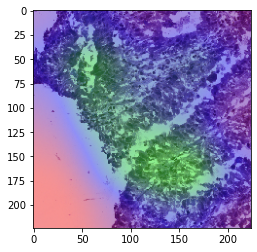

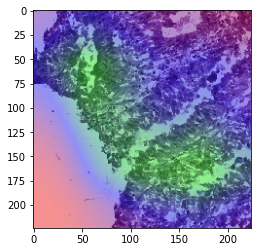

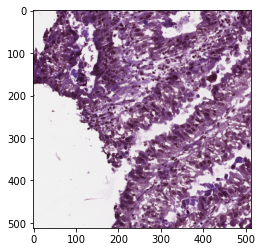

In [63]:
plt.figure()
plt.imshow(cv2.imread(simp_gt_address))
plt.figure()
plt.imshow(cv2.imread(simp_pr_address))
plt.figure()
plt.imshow(img_original)

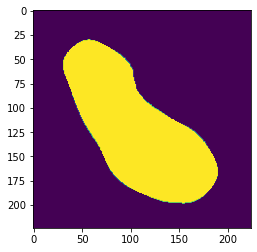

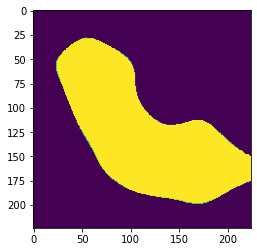

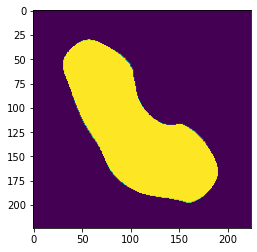

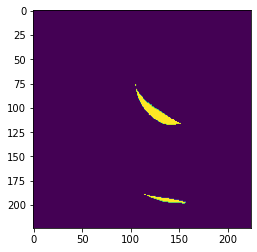

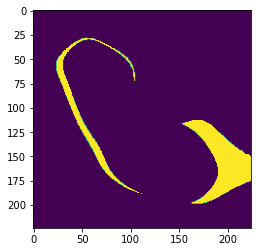

In [51]:
plt.figure()
plt.imshow(img1)
plt.figure()
plt.imshow(img2)
plt.figure()
plt.imshow(img_ov)
plt.figure()
plt.imshow(img_coad_specific)
plt.figure()
plt.imshow(img_brca_specific)

[54, 66, 177, 357]
[350, 258, 162, 197]
[246, 427, 4, 3]
[241, 425, 4, 2]


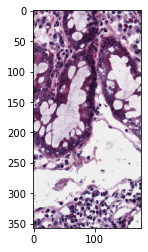

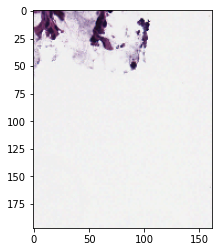

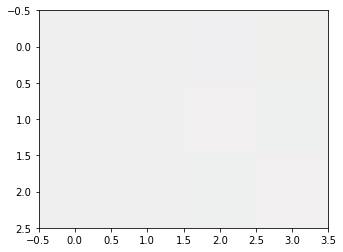

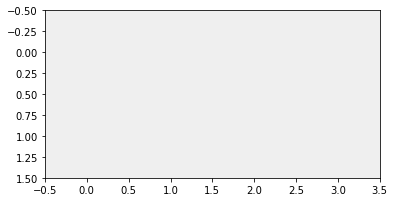

In [66]:
resized_bwa = cv2.resize(img_brca_specific, (512, 512),interpolation = cv2.INTER_NEAREST) #since overlap of heatmaps is on 224X224 but we want the crop of the original image
boxed_image, boxes = get_bb(img2_original,resized_bwa)
cropped_img_list = crop_based_on_coo(orig_img_address,[boxes[i] for i in boxes.keys()])
for n,pils in enumerate(cropped_img_list):
    key_val = list(boxes.keys())[n]
    print(boxes[key_val])
    plt.figure()
    plt.imshow(pils)


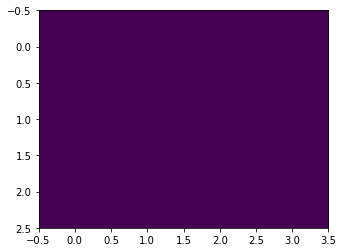